# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [10]:
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.model_selection import train_test_split

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [11]:
# Use 70% of the data for training and the remaineder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=38, test_size=0.30)

In [12]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler().fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_scaler = MinMaxScaler().fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [13]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

lstm_model = Sequential()

number_units = 50
dropout = 0.2

lstm_model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )

lstm_model.add(Dropout(dropout))
lstm_model.add(LSTM(units=number_units, return_sequences=True))
lstm_model.add(Dropout(dropout))
lstm_model.add(LSTM(units=number_units))
lstm_model.add(Dropout(dropout))
lstm_model.add(Dense(1))

In [17]:
# Compile the model
lstm_model.compile(optimizer="adam", loss="mean_squared_error")

In [18]:
# Summarize the model
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [19]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
lstm_model.fit(X_train, y_train, epochs=30, shuffle=False, batch_size=1, verbose=1)

Epoch 1/30
372/372 [==============================] - 5s 6ms/step - loss: 0.0639
Epoch 2/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0510
Epoch 3/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0542
Epoch 4/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0489
Epoch 5/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0497
Epoch 6/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0518
Epoch 7/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0502
Epoch 8/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0478
Epoch 9/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0475
Epoch 10/30
372/372 [==============================] - 3s 7ms/step - loss: 0.0467
Epoch 11/30
372/372 [==============================] - 3s 7ms/step - loss: 0.0469
Epoch 12/30
372/372 [==============================] - 2s 6ms/step - loss: 0.0465
Epoch 13/30
372/372 [====

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [20]:
# Evaluate the model
lstm_model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 3ms/step - loss: 0.0395


0.03945094347000122

In [21]:
# Make some predictions
lstm_predicted = lstm_model.predict(X_test)

In [23]:
# Recover the original prices instead of the scaled version
predicted_prices = y_scaler.inverse_transform(lstm_predicted)
real_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,7301.259766,5945.761230
2019-02-21,8344.780273,6490.826660
2019-02-22,5350.640137,6660.468262
2019-02-23,6376.319824,6097.861816
2019-02-24,4056.750000,6665.656738


In /Users/martinrasumoff/.conda/envs/pyvizenv/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/martinrasumoff/.conda/envs/pyvizenv/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/martinrasumoff/.conda/envs/pyvizenv/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/martinrasumoff/.conda/envs/pyvizenv/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

<AxesSubplot:>

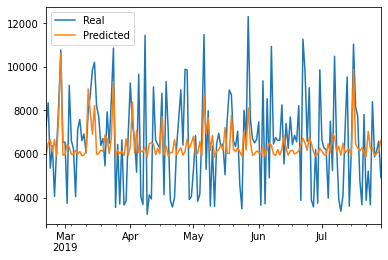

In [25]:
# Plot the real vs predicted values as a line chart
stocks.plot()